# Land with varying evaporative flux
To investigate the Persian Gulf, we run a simulation with evaporative flux much lower over a section of the land so we see descent in this region.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import scipy.signal
import scipy.stats
import numpy_indexed
# Use custom matplotlib style for publishing
plt.style.use(os.environ['PWD']+'/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 1.2          # make lines bigger for presentation

In [2]:
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
from isca_tools.utils.constants import g, R, radius_earth
from isca_tools.utils import area_weighting, annual_time_slice
from isca_tools.utils.ds_slicing import annual_mean
from isca_tools.convection import dry_profile_temp, moist_profile, lcl_temp, dry_profile_pressure

In [3]:
# Load dataset - at surface and in free troposphere
use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
exp_dir = 'rossbypalooza/variable_evap_flux/'
exp_names = ['evap=0']
# rot_rate = [0.5, 1, 2]
# exp_dir = 'rossbypalooza/lat_0/'
# rot_rate = [1]
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/ras_conv/'

# only keep variables required to compute relative humidity and MSE
var_keep = ['temp', 'sphum', 'height', 'klzbs', 'convflag', 'swdn_toa', 'olr', 't_surf', 'precipitation', 'ucomp', 'omega', 'vcomp']

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']
# rot_rate = [1, 2]
n_exp = len(exp_names)
color_seq_rot = plt.cm.jet(np.linspace(0,1,n_exp))
ds = []
albedo = []
tau_sw = []
tau_lw = []
omega = []
time_ind_start = 0  
# time_ind_start = 100
# time_ind_final = 1467       # so both experiments are of same length
time_ind_final = 9999999999999999
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for j in range(n_exp):
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[j]).isel(time=slice(time_ind_start, time_ind_final))
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')[var_keep].load()]  # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        omega += [namelist['constants_nml']['omega']]
        pbar.update(1)
omega = np.asarray(omega)        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size

100%|██████████| 1/1 [00:21<00:00, 21.09s/it]


In [4]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(pfull)), pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

In [5]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

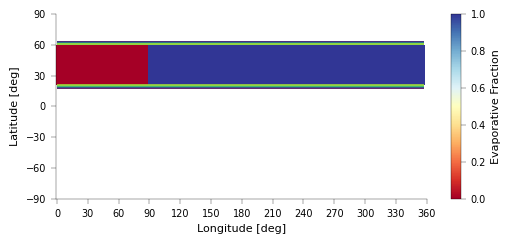

In [6]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land.nc')
land_evap_file_name = os.path.join(job_dir, exp_dir, exp_names[0], 'land_evap_prefactor.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]       # get the longitude coordinates of land
    lat_land_min = float(lat_land.min())
    lat_land_max = float(lat_land.max())
    evap_fraction = xr.load_dataset(land_evap_file_name)
    im = ax.pcolormesh(evap_fraction.lon, evap_fraction.sel(lat=lat_land).lat, 
                       evap_fraction.land_evap_prefactor.sel(lat=lat_land), cmap='RdYlBu', vmin=0, vmax=1)
    plt.colorbar(im, ax=ax, label='Evaporative Fraction')
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [7]:
# Keep track of regions with high vs low evaporative fraction
land_lat_ind = numpy_indexed.indices(np.round(ds[0].lat.to_numpy(), 0), np.round(np.unique(lat_land), 0))
land_low_evap_lon_ind = numpy_indexed.indices(ds[0].lon, evap_fraction.where(evap_fraction.isel(lat=land_lat_ind).land_evap_prefactor<1, drop=True).lon)
land_high_evap_lon_ind = numpy_indexed.indices(ds[0].lon, evap_fraction.where(evap_fraction.land_evap_prefactor==1, drop=True).lon)

label_regions = ['Low', 'High']
ds_regions = [ds[0].isel(lon=land_low_evap_lon_ind), ds[0].isel(lon=land_high_evap_lon_ind)]
n_regions = len(ds_regions)

In [8]:
def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lat_ax == 'x':
                var = ax[i].get_ylim()[0]
                xlim = ax[i].get_xlim()
                ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_ylim(var, ax[i].get_ylim()[1])
                ax[i].set_xlim(xlim)
            elif lat_ax == 'y':
                var = ax[i].get_xlim()[0]
                ylim = ax[i].get_ylim()
                ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
                ax[i].set_xlim(var, ax[i].get_xlim()[1])
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

def show_low_evap_land(ax, lon_min=float(ds_regions[0].lon[0]), lon_max=float(ds_regions[0].lon[-1]), 
                       lon_ax='x', color_low_evap='r', lw_land=4):
    if is_land_data:
        if not isinstance(ax, (list, np.ndarray)):
            raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
        for i in range(len(ax)):
            if lon_ax == 'x':
                ylim = ax[i].get_ylim()
                xlim = ax[i].get_xlim()
                ax[i].hlines(ylim[0], lon_min, lon_max, color=color_low_evap, lw=lw_land)
                ax[i].set_ylim(ylim)
                ax[i].set_xlim(xlim)
            elif lon_ax == 'y':
                xlim = ax[i].get_xlim()
                ylim = ax[i].get_ylim()
                ax[i].vlines(xlim[0], lon_min, lon_max, color=color_low_evap, lw=lw_land)
                ax[i].set_xlim(xlim)
                ax[i].set_ylim(ylim)
            else:
                raise ValueError(f'lat_ax must be either x or y, but {lon_ax} was given.')

## Do we get ascent and descent over same latitudes with different evap fraction?


In [9]:
n_year_days = 360
lat_equator_max = 10
wind_pressure_ft = np.zeros((n_regions, n_year_days, ds[0].coords['lat'].size))
precipitation_annual_mean = np.zeros((n_regions, n_year_days, ds[0].coords['lat'].size))
convflag_annual_mean = np.zeros((n_regions, n_year_days, ds[0].coords['lat'].size))
klzbs_annual_mean = np.zeros((n_regions, n_year_days, ds[0].coords['lat'].size))
sphum_surf_annual_mean = np.zeros((n_regions, n_year_days, ds[0].coords['lat'].size))
rh_surf_annual_mean = np.zeros((n_regions, n_year_days, ds[0].coords['lat'].size))
mse_surf_annual_mean = np.zeros((n_regions, n_year_days, ds[0].coords['lat'].size))
mse_surf_equator_mean = np.zeros(n_regions)
for i in tqdm(range(n_regions)):
    # Take zonal and time mean
    ds_use = annual_mean(ds_regions[i].mean(dim='lon'))
    wind_pressure_ft[i] = ds_use.omega.isel(pfull=ind_ft).to_numpy()
    precipitation_annual_mean[i] = ds_use.precipitation.to_numpy()
    convflag_annual_mean[i] = ds_use.convflag.to_numpy()
    klzbs_annual_mean[i] = ds_use.klzbs.to_numpy()
    sphum_surf_annual_mean[i] = ds_use.sphum.isel(pfull=ind_surf).to_numpy()
    rh_surf_annual_mean[i] = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
    mse_surf_annual_mean[i] = moist_static_energy(ds_use.isel(pfull=ind_surf).temp, ds_use.isel(pfull=ind_surf).sphum, 
                                                  ds_use.isel(pfull=ind_surf).height)
    mse_surf_equator_mean[i] = moist_static_energy(ds_use.isel(pfull=ind_surf).temp, ds_use.isel(pfull=ind_surf).sphum, 
                                                   ds_use.isel(pfull=ind_surf).height
                                                   ).sel(lat=slice(-lat_equator_max, lat_equator_max)).mean(dim=['lat', 'time'])

100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


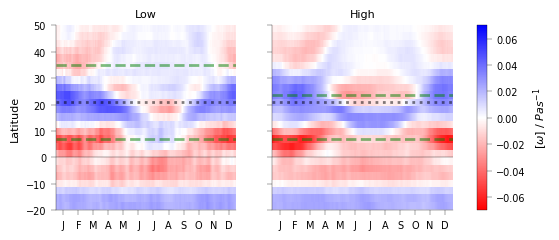

In [10]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
kernel_smooth = np.ones((30, 2))/(30*2)    # take monthly average and average over 2 latitude coordinates
# kernel_smooth = None
vmax = 0.07
lat_equator_inds = np.where(np.abs(ds[0].lat)<lat_equator_max)[0]
lat_subtrop_inds = np.where(np.logical_and(np.abs(ds[0].lat)>=lat_land_min, np.abs(ds[0].lat)<40))[0]
lat_equator_max_ascent = np.zeros(n_regions)
lat_subtrop_max_ascent = np.zeros(n_regions)

fig, ax = plt.subplots(1,n_regions, figsize=(n_regions*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_regions == 1:
    ax = [ax]
for i in range(n_regions):
    # im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(wind_pressure_ft[i]), cmap='bwr_r', vmin=-0.03, vmax=0.03,
    #                       shading='gouraud')
    if kernel_smooth is not None:
        array_smooth = np.transpose(scipy.signal.convolve2d(wind_pressure_ft[i], kernel_smooth, 'same', 'wrap'))
    else:
        array_smooth = np.transpose(wind_pressure_ft[i])
    # sum over year for equator as expect ascent year around
    lat_equator_max_ascent[i] = ds_regions[i].lat[lat_equator_inds[np.sum(array_smooth[lat_equator_inds], axis=1).argmin()]]
    lat_subtrop_max_ascent[i] = ds_regions[i].lat[lat_subtrop_inds[np.min(array_smooth[lat_subtrop_inds], axis=1).argmin()]]
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, array_smooth, cmap='bwr_r', 
                      vmin=-vmax, vmax=vmax)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axhline(lat_equator_max_ascent[i], color='green', linestyle='--', lw=2, alpha=0.5)
    ax[i].axhline(lat_subtrop_max_ascent[i], color='green', linestyle='--', lw=2, alpha=0.5)
    ax[i].axhline(lat_land_min, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].axhline(lat_land_max, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].set_title(label_regions[i])
ax[0].set_ylim(-20, 50)
plt.colorbar(im, ax=ax, label='$[\omega]$ / $Pas^{-1}$')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

In [11]:
print(f"Equator latitude of ascent: {lat_equator_max_ascent}")
print(f"Subtropics latitude of ascent: {lat_subtrop_max_ascent}")

Equator latitude of ascent: [6.97653355 6.97653355]
Subtropics latitude of ascent: [34.88252099 23.72017393]


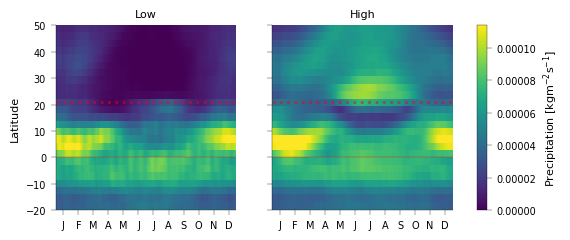

In [12]:
vmax = precipitation_annual_mean.max()*0.7
fig, ax = plt.subplots(1,n_regions, figsize=(n_regions*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_regions == 1:
    ax = [ax]
for i in range(n_regions):
    if kernel_smooth is not None:
        im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, 
                              np.transpose(scipy.signal.convolve2d(precipitation_annual_mean[i], kernel_smooth, 'same', 'wrap')), 
                              vmin=0, vmax=vmax)
    else:
        im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(precipitation_annual_mean[i]), vmin=0, vmax=vmax)
    ax[i].axhline(0, color='r', lw=ax_linewidth)
    ax[i].axhline(lat_land_min, color='r', linestyle=':', lw=2, alpha=0.5)
    ax[i].axhline(lat_land_max, color='r', linestyle=':', lw=2, alpha=0.5)
    ax[i].set_title(label_regions[i])
ax[0].set_ylim(-20, 50)
plt.colorbar(im, ax=ax, label='Precipitation [kgm$^{-2}$s$^{-1}$]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

(-20.0, 50.0)

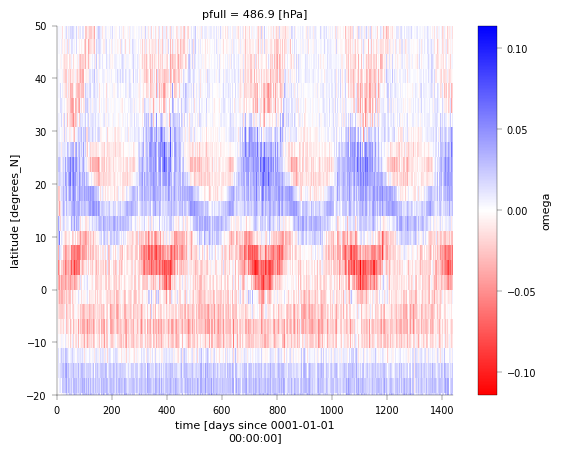

In [13]:
# For 10 degree strip, see peak of precipitation in March in annual average above. 
# Below is a sanity check that this is seen in all years
ds[0].omega.isel(pfull=ind_ft).mean(dim='lon').transpose().plot(cmap='bwr_r')
plt.ylim(-20, 50)

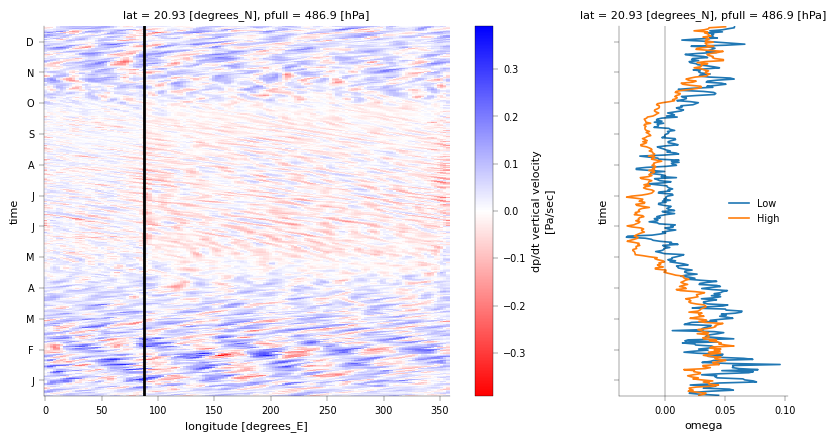

In [14]:
plot_lat = 21
fig, ax = plt.subplots(1,2, figsize=(3*width['one_col'], 2*width['one_col']/ar), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
annual_mean(ds[0].omega.sel(lat=plot_lat, method='nearest').isel(pfull=ind_ft)).plot(ax=ax[0], cmap='bwr_r')
for i in range(n_regions):
    annual_mean(ds_regions[i].omega.isel(pfull=ind_ft).sel(lat=plot_lat, method='nearest')).mean(dim='lon').plot(ax=ax[1], y='time', label=label_regions[i])
ax[0].axvline(ds[0].lon[land_low_evap_lon_ind].max(), color='k', lw=2)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[1].legend()
ax[0].set_yticks(*month_ticks);

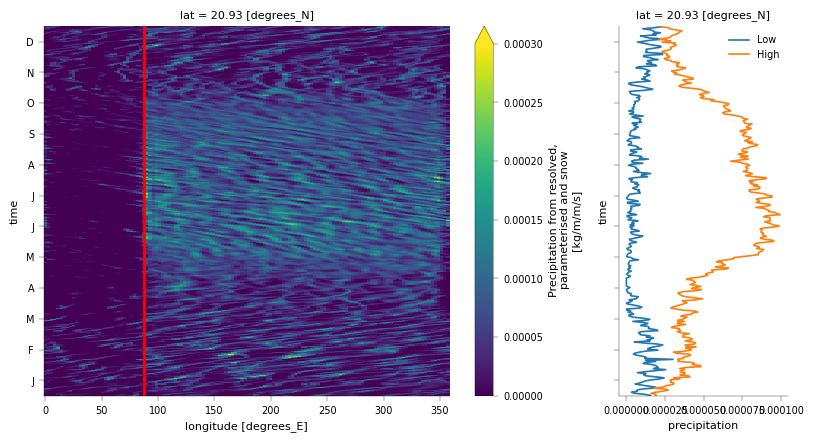

In [15]:
fig, ax = plt.subplots(1,2, figsize=(3*width['one_col'], 2*width['one_col']/ar), sharey=True, gridspec_kw={'width_ratios': [3, 1]})
annual_mean(ds[0].precipitation.sel(lat=plot_lat, method='nearest')).plot(ax=ax[0], cmap='viridis', vmin=0, vmax=0.0003)
for i in range(n_regions):
    annual_mean(ds_regions[i].precipitation.sel(lat=plot_lat, method='nearest')).mean(dim='lon').plot(ax=ax[1], y='time', label=label_regions[i])
ax[0].axvline(ds[0].lon[land_low_evap_lon_ind].max(), color='r', lw=2)
ax[1].legend()
ax[0].set_yticks(*month_ticks);

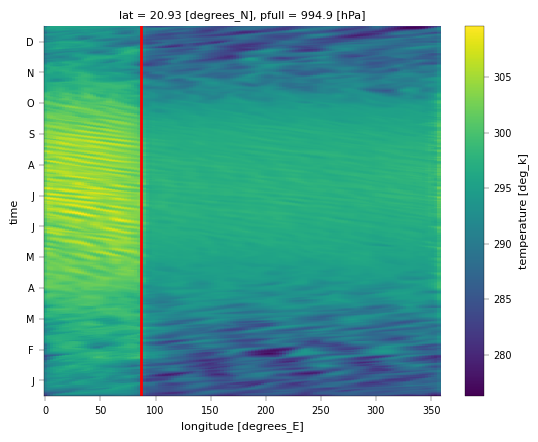

In [16]:
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
annual_mean(ds[0].temp.sel(lat=plot_lat, method='nearest').isel(pfull=ind_surf)).plot(ax=ax, cmap='viridis')
ax.axvline(ds[0].lon[land_low_evap_lon_ind].max(), color='r', lw=2)
ax.set_yticks(*month_ticks);

## Do we see subtropical MSE amplified in the summer?


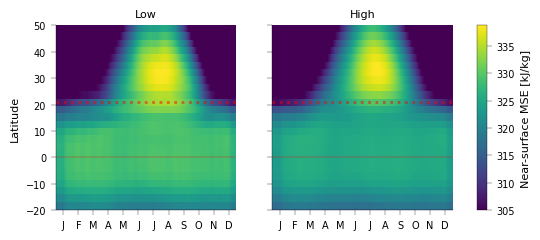

In [17]:
# vmax = precipitation_annual_mean.max()*0.7
fig, ax = plt.subplots(1,n_regions, figsize=(n_regions*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_regions == 1:
    ax = [ax]
for i in range(n_regions):
    if kernel_smooth is not None:
        im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, 
                              np.transpose(scipy.signal.convolve2d(mse_surf_annual_mean[i], kernel_smooth, 'same', 'wrap')), vmin=305)
    else:
        im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(mse_surf_annual_mean[i]), vmin=300)
    ax[i].axhline(0, color='r', lw=ax_linewidth)
    ax[i].axhline(lat_land_min, color='r', linestyle=':', lw=2, alpha=0.5)
    ax[i].axhline(lat_land_max, color='r', linestyle=':', lw=2, alpha=0.5)
    ax[i].set_title(label_regions[i])
ax[0].set_ylim(-20, 50)
plt.colorbar(im, ax=ax, label='Near-surface MSE [kJ/kg]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

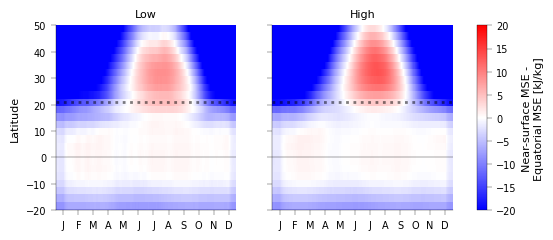

In [18]:
fig, ax = plt.subplots(1,n_regions, figsize=(n_regions*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_regions == 1:
    ax = [ax]
for i in range(n_regions):
    if kernel_smooth is not None:
        im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, 
                              np.transpose(scipy.signal.convolve2d(mse_surf_annual_mean[i]-mse_surf_equator_mean[i], kernel_smooth, 'same', 'wrap')),
                              cmap='bwr', vmin=-20, vmax=20)
    else:
        im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(mse_surf_annual_mean[i]-mse_surf_equator_mean[i]), 
                              cmap='bwr', vmin=-10, vmax=10)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axhline(lat_land_min, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].axhline(lat_land_max, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].set_title(label_regions[i])
ax[0].set_ylim(-20, 50)
plt.colorbar(im, ax=ax, label='Near-surface MSE -\nEquatorial MSE [kJ/kg]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

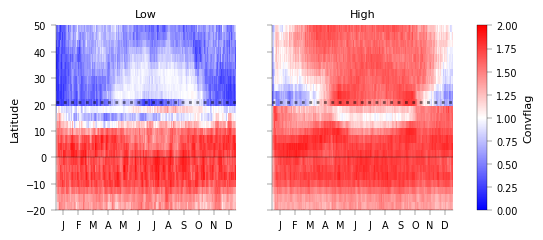

In [19]:
fig, ax = plt.subplots(1,n_regions, figsize=(n_regions*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_regions == 1:
    ax = [ax]
for i in range(n_regions):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(convflag_annual_mean[i]), vmin=0, vmax=2, cmap='bwr')
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axhline(lat_land_min, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].axhline(lat_land_max, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].set_title(label_regions[i])
plt.colorbar(im, ax=ax, label='Convflag')
ax[0].set_ylim(-20, 50)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

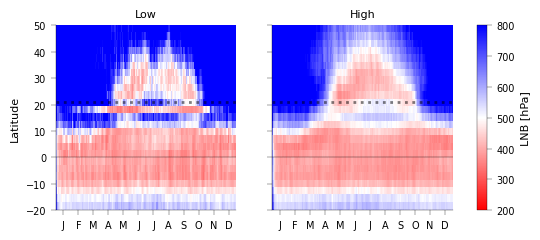

In [20]:
fig, ax = plt.subplots(1,n_regions, figsize=(n_regions*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_regions == 1:
    ax = [ax]
for i in range(n_regions):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(lzb(klzbs_annual_mean[i])), vmin=200, vmax=800, cmap='bwr_r')
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axhline(lat_land_min, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].axhline(lat_land_max, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].set_title(label_regions[i])
ax[0].set_ylim(-20, 50)
plt.colorbar(im, ax=ax, label='LNB [hPa]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

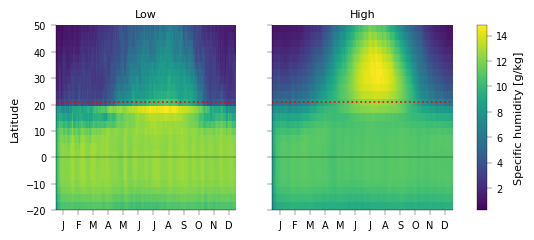

In [21]:
fig, ax = plt.subplots(1,n_regions, figsize=(n_regions*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_regions == 1:
    ax = [ax]
for i in range(n_regions):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(sphum_surf_annual_mean[i])*1000, cmap='viridis')
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axhline(lat_land_min, color='r', linestyle=':')
    ax[i].axhline(lat_land_max, color='r', linestyle=':')
    ax[i].set_title(label_regions[i])
plt.colorbar(im, ax=ax, label='Specific humidity [g/kg]')
plt.ylim(-20, 50)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

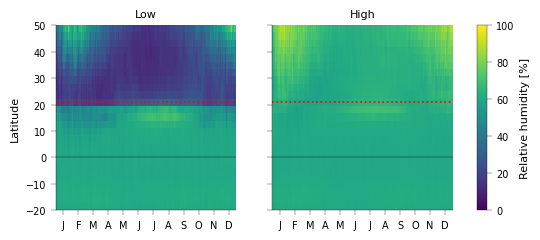

In [22]:
fig, ax = plt.subplots(1,n_regions, figsize=(n_regions*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
if n_regions == 1:
    ax = [ax]
for i in range(n_regions):
    im = ax[i].pcolormesh(np.arange(n_year_days)+0.5, ds[0].lat, np.transpose(rh_surf_annual_mean[i])*100, cmap='viridis', vmin=0, vmax=100)
    ax[i].axhline(0, color='k', lw=ax_linewidth)
    ax[i].axhline(lat_land_min, color='r', linestyle=':')
    ax[i].axhline(lat_land_max, color='r', linestyle=':')
    ax[i].set_title(label_regions[i])
plt.colorbar(im, ax=ax, label='Relative humidity [%]')
ax[0].set_ylim(-20, 50)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude');

### $MSE$ and $T_{FT}$ as function of longitude and latitude averaged over summer JJA
Below I plot $T_{FT}$ and $h_s$ relative to the equatorial average for summer.

Clearly $h_s$ is amplified over both land regions, but $T_{FT}$ is only amplified over the moist land.

Text(0.5, 1.0, '$h_s$ [kJ/kg]')

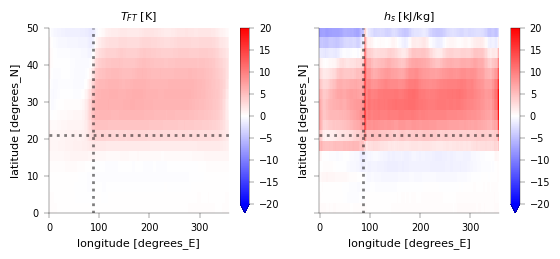

In [23]:
# Equatorial Region average
ds_use = annual_time_slice(ds[0], include_months=[6, 7, 8]).mean(dim='time').sel(lat=slice(-lat_equator_max, lat_equator_max))
temp_ft_summer_equator = ds_use.isel(pfull=ind_ft).temp.mean()
mse_surf_summer_equator = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), 
                                              ds_use.height.isel(pfull=ind_surf)).mean()

# Global distribution summer average
ds_use = annual_time_slice(ds[0], include_months=[6, 7, 8]).mean(dim='time')
mse_surf_summer = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), ds_use.height.isel(pfull=ind_surf))
mse_ft_summer = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual), 
                                    ds_use.height.isel(pfull=ind_ft))

fig, ax = plt.subplots(1,2, figsize=(2*width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
(ds_use.temp.isel(pfull=ind_ft) - temp_ft_summer_equator).plot(vmin=-20, vmax=20, cmap='bwr', ax=ax[0], cbar_kwargs={'label': None})
(mse_surf_summer - mse_surf_summer_equator).plot(ax=ax[1], cmap='bwr', vmin=-20, vmax=20)
for i in range(len(ax)):
    ax[i].axhline(lat_land_min, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].axhline(lat_land_max, color='k', linestyle=':', lw=2, alpha=0.5)
    ax[i].axvline(ds[0].lon[land_low_evap_lon_ind.max()], color='k', linestyle=':', lw=2, alpha=0.5)
ax[0].set_ylim(0, 50)
ax[0].set_title('$T_{FT}$ [K]')
ax[1].set_title('$h_s$ [kJ/kg]')

(-20.0, 50.0)

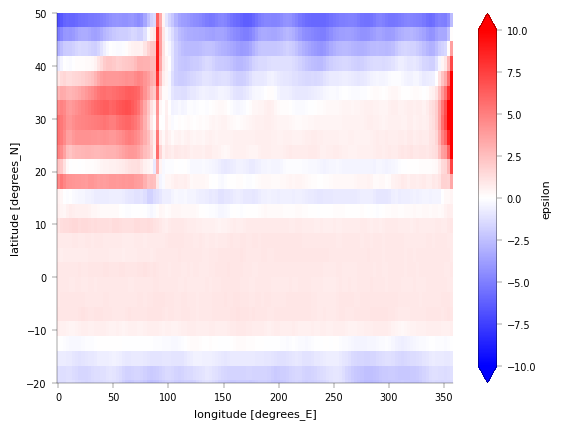

In [111]:
ds_use = annual_time_slice(ds[0], include_months=[6, 7, 8])
ds_use['mse_surf'] = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), ds_use.height.isel(pfull=ind_surf))
ds_use['mse_ft'] = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual), 
                                    ds_use.height.isel(pfull=ind_ft))
ds_use['epsilon'] = ds_use.mse_surf - ds_use.mse_ft
ds_use.epsilon.mean(dim='time').plot(vmin=-10, vmax=10, cmap='bwr')
plt.ylim(-20, 50)

Text(0.5, 1.0, '$h_s - h_{FT}^*$ [kJ/kg]')

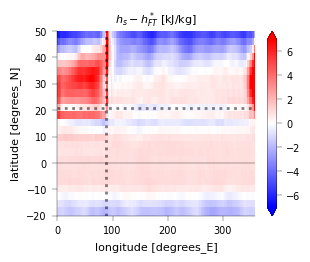

In [24]:
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
(mse_surf_summer - mse_ft_summer).plot(ax=ax, cmap='bwr', vmin=-7, vmax=7)
ax.axhline(lat_land_min, color='k', linestyle=':', lw=2, alpha=0.5)
ax.axhline(lat_land_max, color='k', linestyle=':', lw=2, alpha=0.5)
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(ds[0].lon[land_low_evap_lon_ind.max()], color='k', linestyle=':', lw=2, alpha=0.5)
ax.set_ylim(-20, 50)
ax.set_title('$h_s - h_{FT}^*$ [kJ/kg]')

### Circulation
Below, we see that there is an anomalously anticyclonic weather sytem over the dry land region in summer.

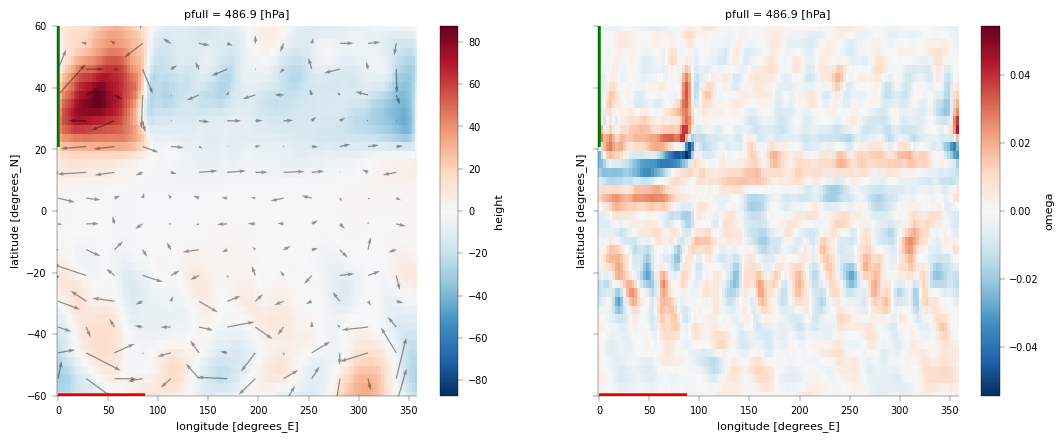

In [36]:
ds_use = annual_time_slice(ds[0].isel(pfull=ind_ft), include_months=[6, 7, 8]).mean(dim='time')
spacing = {'lat': 3, 'lon': 10}
pu, pv = (ds_use.ucomp - ds_use.ucomp.mean(dim='lon'))[::spacing['lat'], ::spacing['lon']], \
    (ds_use.vcomp - ds_use.vcomp.mean(dim='lon'))[::spacing['lat'], ::spacing['lon']]

fig, ax = plt.subplots(1,2, figsize=(4*width['one_col'], 2*width['one_col']/ar), sharey=True, sharex=True)
(ds_use.height - ds_use.height.mean(dim='lon')).plot(ax=ax[0])
ax[0].quiver(ds_use.lon[::spacing['lon']], ds_use.lat[::spacing['lat']], pu, pv, alpha=0.4)
(ds_use.omega - ds_use.omega.mean(dim='lon')).plot(ax=ax[1])
ax[0].set_ylim(-60, 60)
show_land(ax, lat_ax='y')
show_low_evap_land(ax)

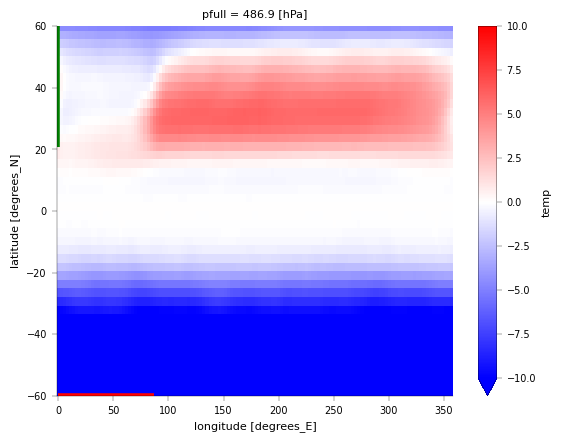

In [26]:
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar), sharey=True, sharex=True)
(ds_use.temp - ds_use.temp.sel(lat=0, method='nearest')).plot(ax=ax, vmin=-10, vmax=10, cmap='bwr')
ax.set_ylim(-60, 60)
show_land([ax], lat_ax='y')
show_low_evap_land([ax])

### Temperature Profile
Below I compare the temperature profile in the two different evaporative regimes, averaged over summer. Clearly the LCL is further from the surface for the low evap region, but also above the LCL, the temperature profile is in-between the moist (dashed) and dry (dotted) adaiabat. Whereas in the moist region, the profile stays closer to the moist profile.

In [27]:
ds_regions_profile = []
with tqdm(total=n_regions, position=0, leave=True) as pbar:
    for j in range(n_exp):
        ds_use = isca_tools.load_dataset(exp_dir + exp_names[j]).isel(time=slice(time_ind_start, time_ind_final))[['temp', 'sphum', 'height']]
        ds_use = ds_use.sel(lat=slice(lat_land_min-0.1, lat_land_max+0.1))
        ds_use = annual_mean(annual_time_slice(ds_use, include_months=[6, 7, 8]))
        ds_regions_profile += [ds_use.isel(lon=land_low_evap_lon_ind).load()]
        pbar.update(1)
        ds_regions_profile += [ds_use.isel(lon=land_high_evap_lon_ind).load()]
        pbar.update(1)

100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


Text(0, 0.5, 'Pressure [hPa]')

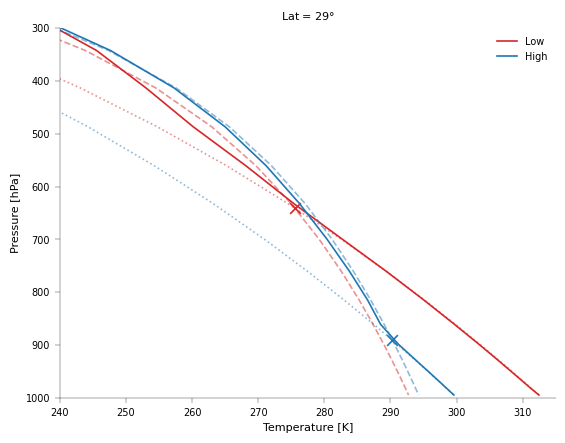

In [28]:
color_regions = [default_colors[3], default_colors[0]]
fig, ax = plt.subplots(1,1, figsize=(2*width['one_col'], 2*width['one_col']/ar))
for i in range(n_regions):
    ds_use = ds_regions_profile[i].mean(dim=['lon', 'time']).isel(lat=3)
    ax.plot(ds_use.temp, ds_regions_profile[0].pfull, label=label_regions[i], color=color_regions[i])
    profile_dry = dry_profile_temp(ds_use.temp.sel(pfull=np.inf, method='nearest'), p_surface, ds_regions_profile[0].pfull*100)
    ax.plot(profile_dry, ds_regions_profile[0].pfull, color=color_regions[i], linestyle=':', alpha=0.5)
    lcl_temp_use = lcl_temp(ds_use.temp.sel(pfull=np.inf, method='nearest'), p_surface, ds_use.sphum.sel(pfull=np.inf, method='nearest'))
    lcl_pressure_use = dry_profile_pressure(ds_use.temp.sel(pfull=np.inf, method='nearest'), p_surface, lcl_temp_use)
    ax.scatter(lcl_temp_use, lcl_pressure_use/100, marker='x', color=color_regions[i], s=60)
    profile_moist = moist_profile(float(lcl_temp_use), float(lcl_pressure_use), ds_regions_profile[0].pfull*100)
    ax.plot(profile_moist, ds_regions_profile[0].pfull, color=color_regions[i], linestyle='--', alpha=0.5)
ax.legend()
ax.set_ylim(300, 1000)
ax.set_xlim(240, 315)
ax.invert_yaxis()
ax.set_title(f'Lat = {int(ds_use.lat)}$\degree$')
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Pressure [hPa]')

(150.0, 250.0)

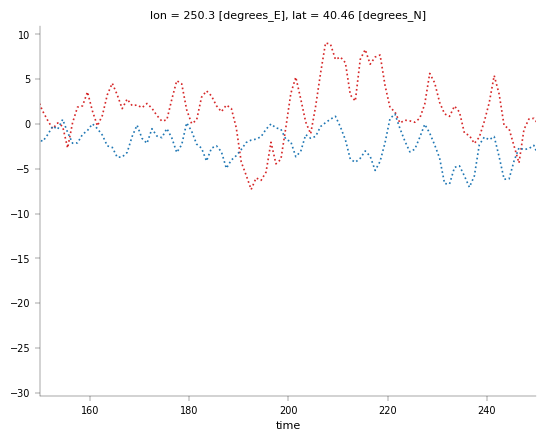

In [118]:
for i in range(n_regions):
    ds_use = annual_mean(ds_regions[i].sel(lat=40, lon=50+200*i, method='nearest'))
    var = moist_static_energy(ds_use.temp.isel(pfull=0), ds_use.sphum.isel(pfull=0), 0) - \
          moist_static_energy(ds_use.temp.isel(pfull=1), sphum_sat(ds_use.temp.isel(pfull=1), pressure_ft_actual), ds_use.height.isel(pfull=1))
    var.plot(color=color_regions[i], linestyle=':')
    # moist_static_energy(ds_use.temp.isel(pfull=0), ds_use.sphum.isel(pfull=0), 0).plot(color=color_regions[i])
    # ds_regions[i].temp.isel(pfull=0).sel(lat=40, lon=50, method='nearest').plot(color=color_regions[i])
# plt.xlim(500, 700)
plt.xlim(150, 250)